# BROUILLON

In [5]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance


[*********************100%***********************]  1 of 1 completed


Price                     Adj Close     Close      High       Low      Open  \
Ticker                     EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X   
Datetime                                                                      
2025-01-01 05:00:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:01:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:02:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:03:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:04:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:05:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:06:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:07:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:08:00+00:00  1.035197  1.035197  1.035197  1.035197  1.035197   
2025-01-01 05:09:00+00:00  1.035197  1.035197  1.035

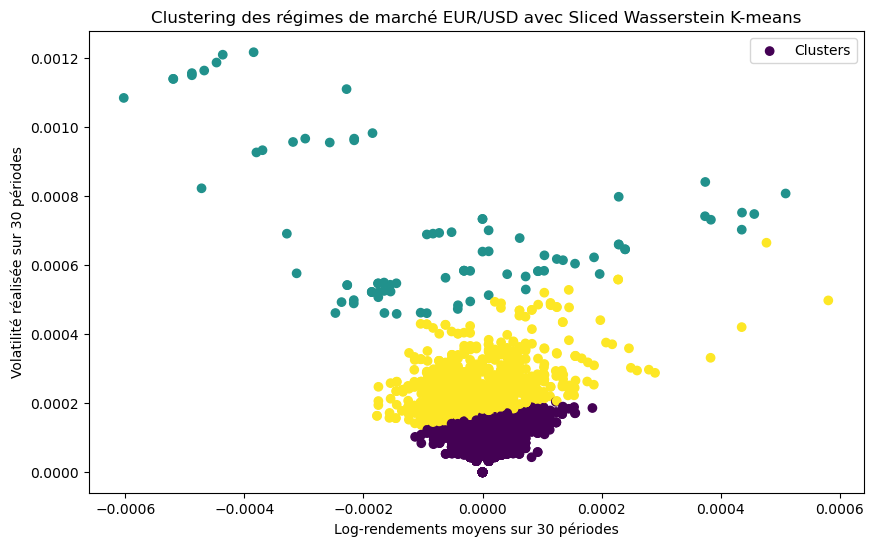

In [13]:
# Fonction pour charger les données EUR/USD
def load_data_multivariable_yf(window=10):
    pair = "EURUSD=X"
    data = yf.download(pair, start="2025-01-01", end="2025-01-07", interval="1m")
    print(data.head(10))
    # Calcul des log-rendements
    data['Log_Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data['Log_Returns'] = data['Log_Returns'].fillna(0)
    
    # Calcul de la volatilité réalisée (écart-type des log-rendements sur la fenêtre)
    data['Realized_Volatility'] = data['Log_Returns'].rolling(window=window).std()

    # Moyennes glissantes pour les log-rendements
    data['Avg_Log_Returns'] = data['Log_Returns'].rolling(window=window).mean()

    # Filtrer les lignes sans données valides
    data = data.dropna()

    # Combinaison des variables dans un tableau multivarié
    data_multivariable = data[['Avg_Log_Returns', 'Realized_Volatility']].values
    return data, data_multivariable

# Fonction pour projeter des distributions multivariées sur des axes aléatoires
def random_projections(data, n_projections=50):
    n_samples, n_features = data.shape
    projections = np.random.randn(n_projections, n_features)
    projections = projections / np.linalg.norm(projections, axis=1, keepdims=True)
    return np.dot(data, projections.T)

# Implémentation de Sliced Wasserstein K-Means
class SlicedWassersteinKMeans:
    def __init__(self, n_clusters, n_projections=50, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_projections = n_projections
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def fit(self, data):
        # Projections initiales
        projected_data = random_projections(data, self.n_projections)

        # Initialisation avec KMeans classique
        kmeans = KMeans(n_clusters=self.n_clusters)
        labels = kmeans.fit_predict(projected_data)
        self.centroids = [np.mean(data[labels == k], axis=0) for k in range(self.n_clusters)]

        for iteration in range(self.max_iter):
            new_centroids = []
            for k in range(self.n_clusters):
                cluster_points = data[labels == k]
                if len(cluster_points) > 0:
                    centroid = np.mean(cluster_points, axis=0)
                    new_centroids.append(centroid)
                else:
                    new_centroids.append(self.centroids[k])

            new_centroids = np.array(new_centroids)
            shift = np.sum([
                wasserstein_distance(self.centroids[i], new_centroids[i])
                for i in range(self.n_clusters)
            ])
            if shift < self.tol:
                break
            self.centroids = new_centroids

            # Réassignation des labels
            projected_data = random_projections(data, self.n_projections)
            labels = np.array([
                np.argmin([
                    wasserstein_distance(projected_data[i], random_projections(self.centroids[j], self.n_projections))
                    for j in range(self.n_clusters)
                ]) for i in range(len(data))
            ])
        return labels

# Chargement des données multivariables depuis yfinance
data, data_multivariable = load_data_multivariable_yf(window=10)

# Exécution de Sliced Wasserstein K-Means
sliced_wasserstein_kmeans = SlicedWassersteinKMeans(n_clusters=3, n_projections=50)
labels = sliced_wasserstein_kmeans.fit(data_multivariable)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.scatter(data_multivariable[:, 0], data_multivariable[:, 1], c=labels, cmap='viridis', label="Clusters")
plt.xlabel("Log-rendements moyens sur 30 périodes")
plt.ylabel("Volatilité réalisée sur 30 périodes")
plt.title("Clustering des régimes de marché EUR/USD avec Sliced Wasserstein K-means")
plt.legend()
plt.show()

Identification des clusters en fonction des 2 parametres choisis pour faire le backtest

In [78]:
# Chargement des données EUR/USD
def load_data_yf(window=30):
    pair = "EURUSD=X"
    data = yf.download(pair, start="2025-01-01", end="2025-01-07", interval="1m")
    
    # Calcul des log-rendements
    data['Log_Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).fillna(0)
    
    # Calcul de la volatilité réalisée
    data['Realized_Volatility'] = data['Log_Returns'].rolling(window=window).std()

    # Moyennes glissantes pour les log-rendements
    data['Avg_Log_Returns'] = data['Log_Returns'].rolling(window=window).mean()

    # Filtrer les lignes sans données valides
    data = data.dropna()

    # Vérification des colonnes générées
    print("Colonnes disponibles après traitement :", data.columns)
    print(data[['Log_Returns', 'Realized_Volatility', 'Avg_Log_Returns']].head())

    # Combinaison des variables dans un tableau multivarié
    data_multivariable = data[['Avg_Log_Returns', 'Realized_Volatility']].values
    return data, data_multivariable

In [82]:
# Fonction pour projeter des distributions multivariées
def random_projections(data, n_projections=50):
    n_samples, n_features = data.shape
    projections = np.random.randn(n_projections, n_features)
    projections = projections / np.linalg.norm(projections, axis=1, keepdims=True)
    return np.dot(data, projections.T)

In [84]:
# Implémentation de Sliced Wasserstein K-Means
class SlicedWassersteinKMeans:
    def __init__(self, n_clusters, n_projections=50, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_projections = n_projections
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def fit(self, data):
        projected_data = random_projections(data, self.n_projections)
        kmeans = KMeans(n_clusters=self.n_clusters)
        labels = kmeans.fit_predict(projected_data)
        self.centroids = [np.mean(data[labels == k], axis=0) for k in range(self.n_clusters)]

        for iteration in range(self.max_iter):
            new_centroids = []
            for k in range(self.n_clusters):
                cluster_points = data[labels == k]
                if len(cluster_points) > 0:
                    centroid = np.mean(cluster_points, axis=0)
                    new_centroids.append(centroid)
                else:
                    new_centroids.append(self.centroids[k])

            new_centroids = np.array(new_centroids)
            shift = np.sum([
                wasserstein_distance(self.centroids[i], new_centroids[i])
                for i in range(self.n_clusters)
            ])
            if shift < self.tol:
                break
            self.centroids = new_centroids
            projected_data = random_projections(data, self.n_projections)
            labels = np.array([
                np.argmin([
                    wasserstein_distance(projected_data[i], random_projections(self.centroids[j], self.n_projections))
                    for j in range(self.n_clusters)
                ]) for i in range(len(data))
            ])
        return labels

In [86]:
# Étape 1 : Charger les données et effectuer le clustering
data, data_multivariable = load_data_yf(window=30)


[*********************100%***********************]  1 of 1 completed

Colonnes disponibles après traitement : MultiIndex([(          'Adj Close', 'EURUSD=X'),
            (              'Close', 'EURUSD=X'),
            (               'High', 'EURUSD=X'),
            (                'Low', 'EURUSD=X'),
            (               'Open', 'EURUSD=X'),
            (             'Volume', 'EURUSD=X'),
            (        'Log_Returns',         ''),
            ('Realized_Volatility',         ''),
            (    'Avg_Log_Returns',         '')],
           names=['Price', 'Ticker'])
Price                     Log_Returns Realized_Volatility Avg_Log_Returns
Ticker                                                                   
Datetime                                                                 
2025-01-01 05:29:00+00:00    0.000000            0.000000        0.000000
2025-01-01 18:03:00+00:00    0.000311            0.000057        0.000010
2025-01-01 18:04:00+00:00    0.000311            0.000079        0.000021
2025-01-01 18:05:00+00:00    0.00010

In [88]:
# Aplatir les colonnes
data.columns = ['_'.join(filter(None, col)) for col in data.columns]

# Vérifiez les nouvelles colonnes
print(data.columns)

Index(['Adj Close_EURUSD=X', 'Close_EURUSD=X', 'High_EURUSD=X', 'Low_EURUSD=X',
       'Open_EURUSD=X', 'Volume_EURUSD=X', 'Log_Returns',
       'Realized_Volatility', 'Avg_Log_Returns'],
      dtype='object')


In [90]:
# Clustering avec Sliced Wasserstein K-Means
sliced_wasserstein_kmeans = SlicedWassersteinKMeans(n_clusters=3, n_projections=50)
labels = sliced_wasserstein_kmeans.fit(data_multivariable)

# Ajouter les clusters aux données
data['Cluster'] = labels

# Calcul des statistiques descriptives pour interpréter les clusters
cluster_stats = data.groupby('Cluster').agg({
    'Avg_Log_Returns': ['mean', 'std'],
    'Realized_Volatility': ['mean', 'std']
})
print("Statistiques des clusters :")
print(cluster_stats)


Statistiques des clusters :
        Avg_Log_Returns           Realized_Volatility          
                   mean       std                mean       std
Cluster                                                        
0             -0.000003  0.000038            0.000246  0.000055
1              0.000001  0.000017            0.000102  0.000033
2              0.000010  0.000130            0.000537  0.000126


In [104]:
# Mapping automatique des clusters aux régimes de marché
cluster_to_regime = {}

for cluster in range(len(cluster_stats)):
    avg_log_return = cluster_stats['Avg_Log_Returns']['mean'].iloc[cluster]
    avg_volatility = cluster_stats['Realized_Volatility']['mean'].iloc[cluster]
    
    # Définir des seuils plus adaptés
    if avg_volatility < 0.00015:  # Faible volatilité
        cluster_to_regime[cluster] = "Calme"
    elif avg_volatility >= 0.00018 and avg_volatility < 0.0004 and abs(avg_log_return) < 0.0003:  # Directionnel
        cluster_to_regime[cluster] = "Directionnel"
    else:  # Incertain
        cluster_to_regime[cluster] = "Incertain"
print("Mapping des clusters vers les régimes :", cluster_to_regime)

# Associer les régimes aux données
data['Regime'] = data['Cluster'].map(cluster_to_regime)

Mapping des clusters vers les régimes : {0: 'Directionnel', 1: 'Calme', 2: 'Incertain'}


In [106]:
data.head(40)

,Adj Close_EURUSD=X,Close_EURUSD=X,High_EURUSD=X,Low_EURUSD=X,Open_EURUSD=X,Volume_EURUSD=X,Log_Returns,Realized_Volatility,Avg_Log_Returns,Cluster,Regime
Datetime,,,,,,,,,,,
2025-01-01 05:29:00+00:00,1.035197,1.035197,1.035197,1.035197,1.035197,0,0.000000,0.000000,0.000000e+00,1,Calme
2025-01-01 18:03:00+00:00,1.035518,1.035518,1.035518,1.035518,1.035518,0,0.000311,0.000057,1.035477e-05,1,Calme
2025-01-01 18:04:00+00:00,1.035840,1.035840,1.035840,1.035840,1.035840,0,0.000311,0.000079,2.071016e-05,1,Calme
2025-01-01 18:05:00+00:00,1.035947,1.035947,1.035947,1.035947,1.035947,0,0.000104,0.000080,2.416252e-05,1,Calme
2025-01-01 18:06:00+00:00,1.036055,1.036055,1.036055,1.036055,1.036055,0,0.000104,0.000081,2.761836e-05,1,Calme
2025-01-01 18:07:00+00:00,1.036592,1.036592,1.036592,1.036592,1.036592,0,0.000518,0.000121,4.488835e-05,1,Calme
2025-01-01 18:08:00+00:00,1.035840,1.035840,1.035840,1.035840,1.035840,0,-0.000725,0.000185,2.071016e-05,0,Directionnel
2025-01-01 18:09:00+00:00,1.035947,1.035947,1.035947,1.035947,1.035947,0,0.000104,0.000186,2.416252e-05,0,Directionnel
2025-01-01 18:10:00+00:00,1.036162,1.036162,1.036162,1.036162,1.036162,0,0.000207,0.000189,3.107001e-05,0,Directionnel


Total PnL: 0.014473156754077178
Sharpe Ratio: -2706.7682474600715


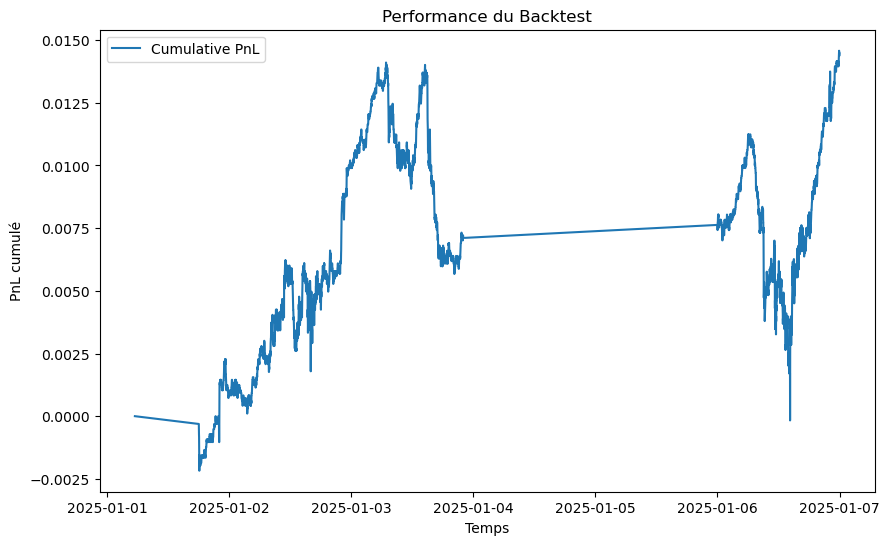

In [52]:
# Étape 2 : Backtesting
def backtest(data, log_returns):
    pnl = []
    positions = []

    for i in range(0, len(data)):
        regime = data['Regime'].iloc[i]
        
        # Stratégie Mean Reversion
        if regime == "Calme":
            if log_returns[i - 1] < 0:
                pnl.append(log_returns[i])  # Achat
                positions.append(1)
            else:
                pnl.append(-log_returns[i])  # Vente
                positions.append(-1)

        # Stratégie Trend Following
        elif regime == "Directionnel":
            if log_returns[i - 1] > 0:
                pnl.append(log_returns[i])  # Achat
                positions.append(1)
            else:
                pnl.append(-log_returns[i])  # Vente
                positions.append(-1)

        # Stratégie Range Trading
        elif regime == "Incertain":
            if i > 1 and positions[-1] == 1:
                pnl.append(-log_returns[i])  # Inverse position
                positions.append(-1)
            else:
                pnl.append(log_returns[i])
                positions.append(1)

    data['PnL'] = pnl
    data['Position'] = positions

    # Calcul des performances
    total_pnl = np.sum(pnl)
    sharpe_ratio = (np.mean(pnl) - 0.03) / np.std(pnl) * np.sqrt(252) if np.std(pnl) != 0 else 0

    return data, total_pnl, sharpe_ratio

# Exécuter le backtesting
backtest_results, total_pnl, sharpe_ratio = backtest(data, data['Log_Returns'].values)

# Résultats
print(f"Total PnL: {total_pnl}")
print(f"Sharpe Ratio: {sharpe_ratio}")

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(backtest_results['PnL'].cumsum(), label='Cumulative PnL')
plt.xlabel('Temps')
plt.ylabel('PnL cumulé')
plt.title('Performance du Backtest')
plt.legend()
plt.show()


Total PnL: 11664.966396689415 €
Balance finale: 21664.966396689415 €
Sharpe Ratio: 30.42173124231823


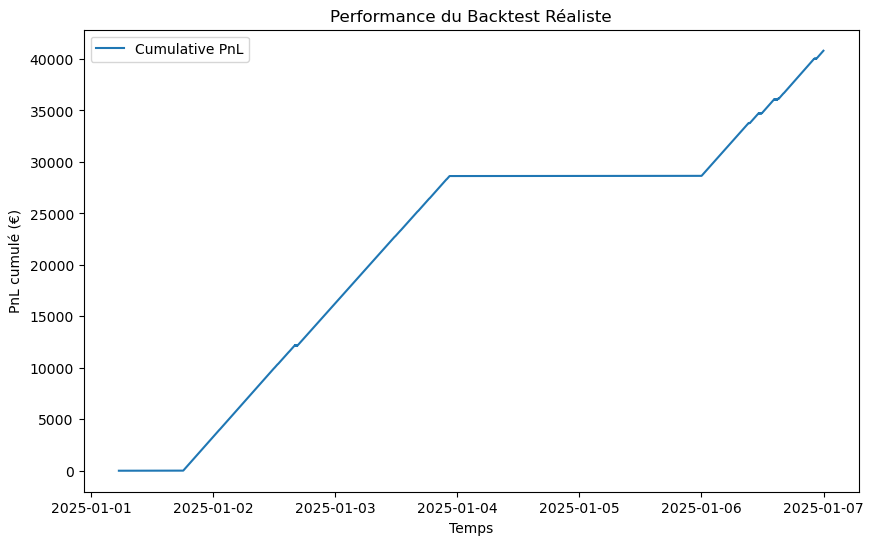

In [108]:
def backtest_realistic(data, log_returns, initial_balance=10000, lot_size=0.1):
    """
    Backtest réaliste pour le marché FX avec gestion du portefeuille.
    
    Arguments :
    - data : DataFrame contenant les données (avec les colonnes 'Regime' et 'Close').
    - log_returns : Log-rendements des prix.
    - initial_balance : Montant initial du portefeuille en euros.
    - lot_size : Taille du lot (0.1 lot = 10 000 unités de base).
    
    Retourne :
    - data : DataFrame mis à jour avec les résultats des trades.
    - total_pnl : PnL total en euros.
    - final_balance : Balance finale du portefeuille.
    """
    balance = initial_balance
    pnl = []
    positions = []
    trades = []  # Liste pour suivre les trades
    trade_pnl = 0
    # Conversion d'un pip en valeur monétaire pour un lot donné (EUR/USD)
    pip_value_per_lot = 10  # Valeur approximative d'un pip pour 1 lot standard (100 000 unités)

    for i in range(len(data)):
        regime = data['Regime'].iloc[i]
        close_price = data['Close_EURUSD=X'].iloc[i]  # Prix de clôture réel
        
        # Stratégie Mean Reversion (Regime "Calme")
        if regime == "Calme":
            if log_returns[i - 1] < 0:  # Achat si rendement précédent est négatif
                entry_price = close_price
                exit_price = close_price * (1 + 0.9)
                trade_pnl = (exit_price - entry_price) * lot_size * pip_value_per_lot
                trades.append(trade_pnl)
                balance += trade_pnl

        # Stratégie Trend Following (Regime "Directionnel")
        elif regime == "Directionnel":
            if log_returns[i - 1] > 0:  # Achat si rendement précédent est positif
                entry_price = close_price
                exit_price = close_price * (1 + 0.9)
                trade_pnl = (exit_price - entry_price) * lot_size * pip_value_per_lot
                trades.append(trade_pnl)
                balance += trade_pnl

        # Stratégie Range Trading (Regime "Incertain")
        elif regime == "Incertain":
            if len(positions) > 0 and positions[-1] == 1:  # Si déjà en position longue
                entry_price = close_price
                exit_price = close_price * (1 + 0.9)
                trade_pnl = (entry_price - exit_price) * lot_size * pip_value_per_lot
                trades.append(trade_pnl)
                balance += trade_pnl
            else:  # Nouvelle position longue
                entry_price = close_price
                exit_price = close_price * (1 + 0.9)
                trade_pnl = (exit_price - entry_price) * lot_size * pip_value_per_lot
                trades.append(trade_pnl)
                balance += trade_pnl

        # Mettre à jour les positions et le PnL
        pnl.append(trade_pnl)
        positions.append(1 if trade_pnl > 0 else -1)

        # Vérification de la balance
        if balance <= 0:
            print("Portefeuille épuisé ! Arrêt du trading.")
            break

    data['PnL'] = pnl
    data['Position'] = positions

    # Calcul des performances
    total_pnl = sum(trades)
    final_balance = balance
    sharpe_ratio = np.mean(trades) / np.std(trades) * np.sqrt(252) if np.std(trades) != 0 else 0

    return data, total_pnl, final_balance, sharpe_ratio


# Exécuter le backtesting réaliste
backtest_results, total_pnl, final_balance, sharpe_ratio = backtest_realistic(
    data, data['Log_Returns'].values, initial_balance=10000, lot_size=1
)

# Résultats
print(f"Total PnL: {total_pnl} €")
print(f"Balance finale: {final_balance} €")
print(f"Sharpe Ratio: {sharpe_ratio}")

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(backtest_results['PnL'].cumsum(), label='Cumulative PnL')
plt.xlabel('Temps')
plt.ylabel('PnL cumulé (€)')
plt.title('Performance du Backtest Réaliste')
plt.legend()
plt.show()


# REGARDER A PARTIR D'ICI

In [177]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


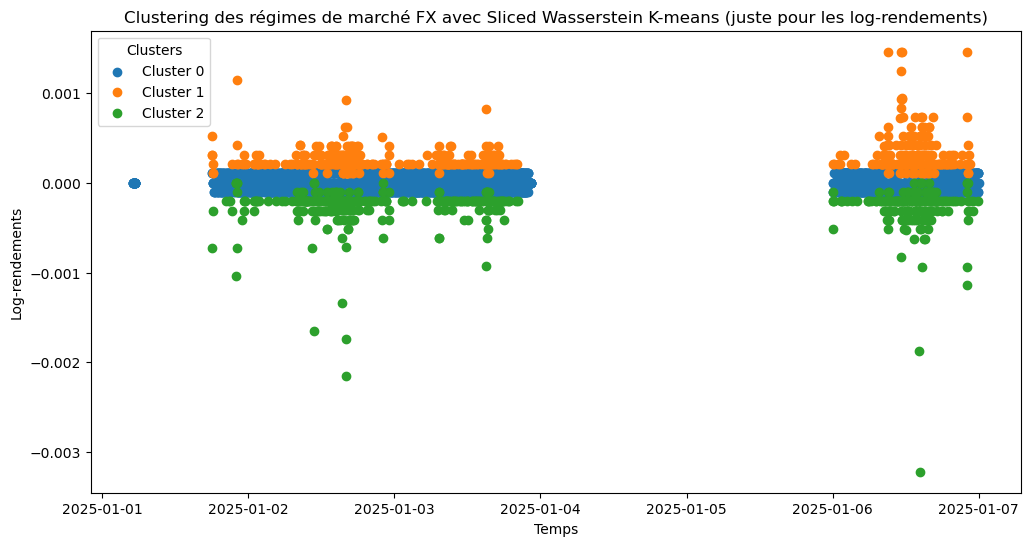

In [192]:
# Chargement des données de prix à partir de Yahoo Finance
def load_data(ticker, start, end, interval="1m"):
    data = yf.download(ticker, start=start, end=end, interval=interval)
    data = data['Close'].dropna()  # Utiliser les prix de clôture
    return data

# Calculer les rendements logarithmiques
def log_returns(data):
    return np.log(data / data.shift(1)).dropna()

# Calcul de la volatilité réalisée
def realized_volatility(data, window=5):
    return data.rolling(window).std().dropna()

# Fonction de calcul de la distance Wasserstein "sliced"
def sliced_wasserstein_distance(X, Y, n_projections=10):
    directions = np.random.randn(n_projections, X.shape[1])
    directions /= np.linalg.norm(directions, axis=1)[:, np.newaxis]
    distances = []
    for theta in directions:
        # Projection des données
        X_proj = np.dot(X, theta)
        Y_proj = np.dot(Y, theta)
        # Tri des projections
        X_sorted = np.sort(X_proj)
        Y_sorted = np.sort(Y_proj)
        # Calcul de la distance Wasserstein unidimensionnelle
        distances.append(np.abs(X_sorted - Y_sorted).mean())
    return np.mean(distances)

# Implémentation de l'algorithme Sliced Wasserstein K-means
class SlicedWassersteinKMeans:
    def __init__(self, n_clusters, n_projections=10, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_projections = n_projections
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def fit(self, data):
        # Initialisation des clusters avec KMeans classique pour obtenir les premiers centroids
        kmeans = KMeans(n_clusters=self.n_clusters)
        labels = kmeans.fit_predict(data)
        self.centroids = [np.mean(data[labels == k], axis=0) for k in range(self.n_clusters)]

        for iteration in range(self.max_iter):
            new_centroids = []
            for k in range(self.n_clusters):
                cluster_points = data[labels == k]
                if len(cluster_points) > 0:
                    centroid = np.mean(cluster_points, axis=0)
                    new_centroids.append(centroid)
                else:
                    new_centroids.append(self.centroids[k])

            new_centroids = np.array(new_centroids)

            # Vérification de la convergence
            shift = np.sum([sliced_wasserstein_distance(self.centroids[i].reshape(1, -1), 
                                                        new_centroids[i].reshape(1, -1), 
                                                        self.n_projections) 
                            for i in range(self.n_clusters)])
            if shift < self.tol:
                break
            self.centroids = new_centroids

            # Réassignation des labels en fonction des nouvelles distances Wasserstein
            labels = np.array([np.argmin([sliced_wasserstein_distance(data[i].reshape(1, -1), 
                                                                      self.centroids[j].reshape(1, -1), 
                                                                      self.n_projections) 
                                          for j in range(self.n_clusters)]) for i in range(len(data))])

        return labels

# Paramètres pour les données et le clustering
ticker = "EURUSD=X"
start_date = "2025-01-01"
end_date = "2025-01-07"
interval = "1m"

# Charger les données de prix et calculer les variables
prices = load_data(ticker, start_date, end_date, interval=interval)
log_returns_data = log_returns(prices)
volatility_data = realized_volatility(log_returns_data)

# Aligner les données
combined_data = pd.concat([log_returns_data, volatility_data], axis=1).dropna()
combined_data.columns = ['Log_Returns', 'Volatility']

# Convertir en numpy array
data_for_clustering = combined_data.values

# Application de l'algorithme de sliced Wasserstein K-means sur les données multivariées
sliced_wasserstein_kmeans = SlicedWassersteinKMeans(n_clusters=3, n_projections=40)
labels = sliced_wasserstein_kmeans.fit(data_for_clustering)

# Ajouter les labels au DataFrame
combined_data['Cluster'] = labels

# Visualisation des résultats
plt.figure(figsize=(12, 6))

# Tracer les log-rendements avec les clusters colorés
for cluster in combined_data['Cluster'].unique():
    cluster_data = combined_data[combined_data['Cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['Log_Returns'], label=f"Cluster {cluster}")

plt.xlabel("Temps")
plt.ylabel("Log-rendements")
plt.title("Clustering des régimes de marché FX avec Sliced Wasserstein K-means (juste pour les log-rendements)")
plt.legend(title="Clusters")
plt.show()


Ici on voit que 0 correspond au régime neutre, 1 à l'achat et 2 à la vente

In [188]:
combined_data.tail()

,Log_Returns,Volatility,Cluster
Datetime,,,
2025-01-06 23:54:00+00:00,0.000000,0.000127,0
2025-01-06 23:55:00+00:00,0.000104,0.000127,0
2025-01-06 23:56:00+00:00,0.000104,0.000057,0
2025-01-06 23:57:00+00:00,-0.000104,0.000087,0
2025-01-06 23:58:00+00:00,0.000000,0.000087,0


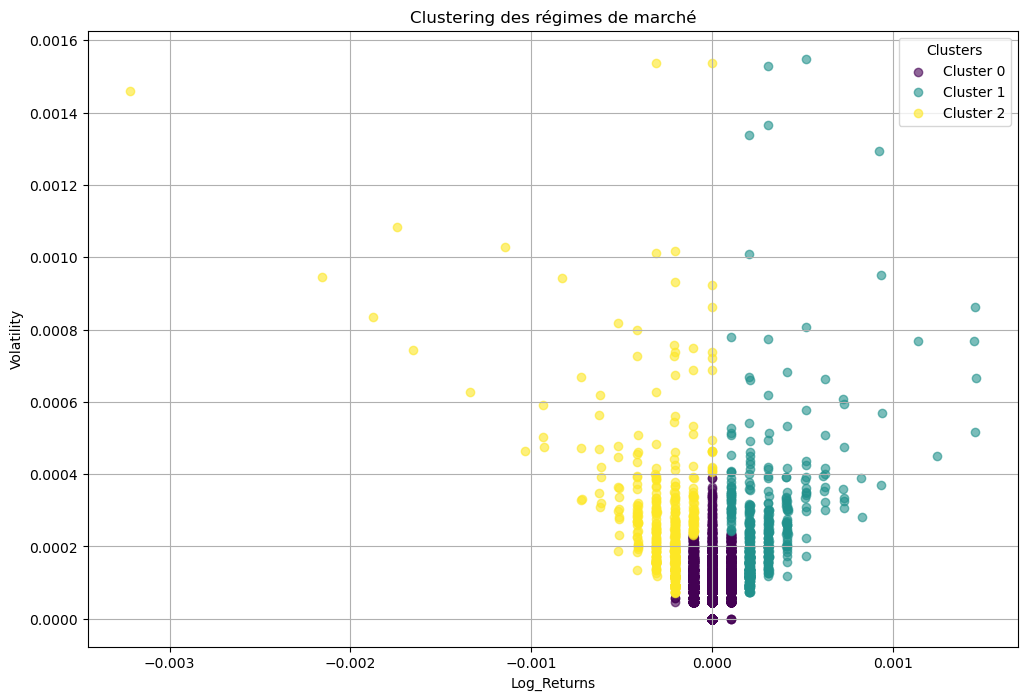

In [194]:
def visualize_clusters_2d(data, param1, param2, cluster_col='Cluster', title="Visualisation des régimes de marché"):
    """
    Visualise les clusters en 2D à partir de deux paramètres.

    Arguments :
    - data : DataFrame contenant les paramètres et les clusters.
    - param1 : str, nom du premier paramètre (axe x).
    - param2 : str, nom du deuxième paramètre (axe y).
    - cluster_col : str, nom de la colonne des clusters (par défaut 'Cluster').
    - title : str, titre du graphique.

    Retour :
    - Affiche un graphique en 2D des paramètres colorés par cluster.
    """
    plt.figure(figsize=(12, 8))
    
    # Obtenir les clusters uniques
    unique_clusters = data[cluster_col].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))
    
    # Tracer chaque cluster
    for idx, cluster in enumerate(unique_clusters):
        cluster_data = data[data[cluster_col] == cluster]
        plt.scatter(
            cluster_data[param1],
            cluster_data[param2],
            color=colors[idx],
            label=f"Cluster {cluster}",
            alpha=0.6
        )
    
    # Ajouter des détails au graphique
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.title(title)
    plt.legend(title="Clusters")
    plt.grid(True)
    plt.show()

# Visualiser les clusters sur les log-rendements et la volatilité
visualize_clusters_2d(
    data=combined_data,
    param1='Log_Returns',
    param2='Volatility',
    cluster_col='Cluster',
    title="Clustering des régimes de marché"
)

## Essayons plusieurs types d'affichages

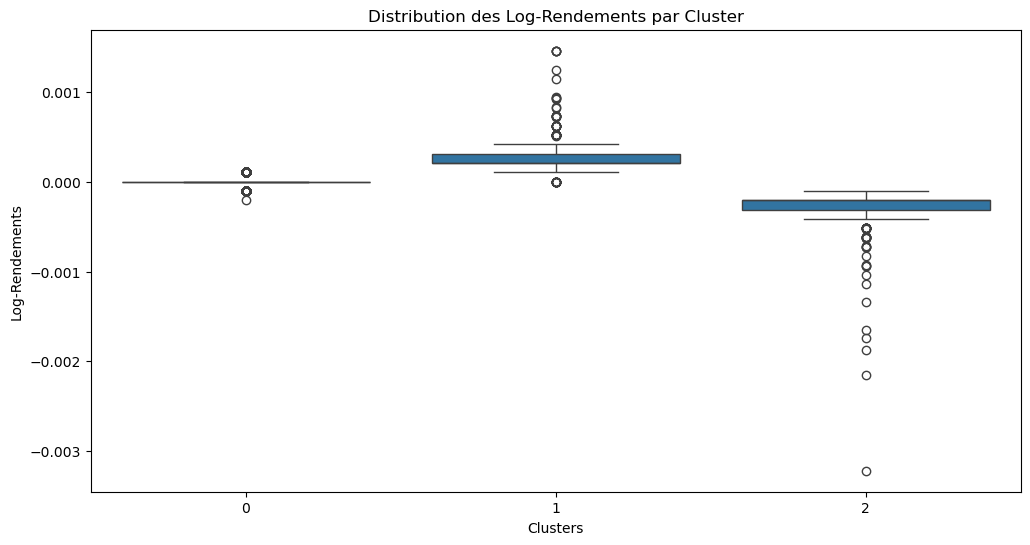

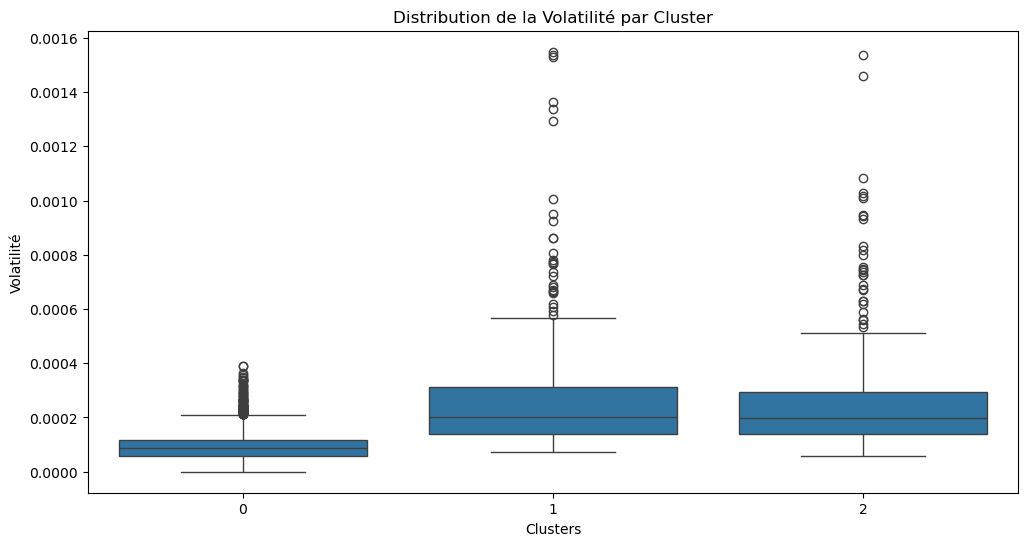

In [144]:
import seaborn as sns

# Boxplot pour les log-rendements
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Log_Returns', data=combined_data)
plt.title('Distribution des Log-Rendements par Cluster')
plt.xlabel('Clusters')
plt.ylabel('Log-Rendements')
plt.show()

# Boxplot pour la volatilité
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Volatility', data=combined_data)
plt.title('Distribution de la Volatilité par Cluster')
plt.xlabel('Clusters')
plt.ylabel('Volatilité')
plt.show()


### Histogramme des Durées des Régimes
voir combien de temps chaque cluster tend à durer (en nombre de points consécutifs).

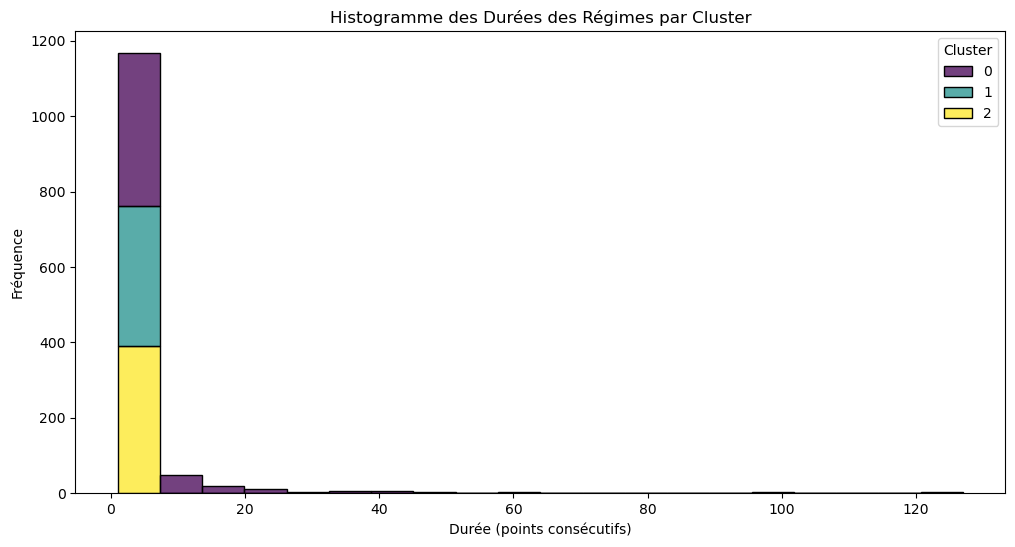

In [159]:
# Calcul des durées des régimes
combined_data['Duration'] = (combined_data['Cluster'] != combined_data['Cluster'].shift()).cumsum()
durations = combined_data.groupby('Duration').size()
duration_per_cluster = combined_data.groupby(['Duration', 'Cluster']).size().reset_index(name='Count')

# Histogramme des durées par cluster
plt.figure(figsize=(12, 6))
sns.histplot(data=duration_per_cluster, x='Count', hue='Cluster', multiple='stack', bins=20, palette='viridis')
plt.title('Histogramme des Durées des Régimes par Cluster')
plt.xlabel('Durée (points consécutifs)')
plt.ylabel('Fréquence')
plt.show()
